In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.metrics import as_cumulative_dynamic_auc_scorer
from sklearn.model_selection import cross_val_score
from sksurv.metrics import cumulative_dynamic_auc
from sklearn.model_selection import KFold
import pickle


In [166]:
# Specify the path to your pickle file
file_path = "../../../dataset/cri_compustat_merged_v8.pkl"

# Open the pickle file for reading
with open(file_path, 'rb') as file:
    # Load the data from the pickle file
    df = pickle.load(file)

df.head()

,CompNo,year,month,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,day_sales_outstanding,working_capital_turnover,price_to_earnings,dividend_payout_ratio,retention_ratio,gross_margin_ratio,operating_profit_margin,ebitda_margin,debt_service_coverage_ratio,interest_coverage_ratio
0,42404,2000.0,1,0.089239,0.011089,0.677551,0.332808,1.411466,0.027249,-0.148249,...,197946.597222,0.000000,-5.000000,-0.0,1.0,-5.251700e+06,-2.189250e+07,-2.185540e+07,-149041.103448,-297211.000000
1,37610,2000.0,1,0.089239,0.011089,0.087376,-0.524732,0.906364,-0.071829,0.000292,...,190.722132,2.177571,-1.220833,0.0,1.0,2.498284e+01,-7.402171e+01,-6.856532e+01,-0.904380,1.490291
2,49536,2000.0,1,0.313050,0.007314,3.693176,0.625516,1.872712,1.010148,-0.069998,...,0.000000,0.036899,-78.333333,-0.0,1.0,7.542644e+01,-2.309701e+02,-1.503731e+02,-11.081841,-430.222222
3,32417,2000.0,1,0.089239,0.011089,6.165654,0.863910,1.275166,0.184606,0.013360,...,269.176235,0.551135,66.510333,0.0,1.0,5.234158e+01,-2.327468e+01,-1.952816e+01,-395.933333,777.750000
4,44933,2000.0,1,0.089239,0.011089,0.629410,-0.874122,0.000000,0.000000,0.004436,...,0.000000,-2.766467,19.196429,0.0,1.0,7.495250e+01,3.133312e+01,4.316023e+01,0.020216,2.013002


In [167]:
df['Duration'] = df['Duration'].dt.total_seconds() / (24 * 60 * 60)
df['Default'] = df['Default'].map(lambda x : False if x == 0.0 else True)

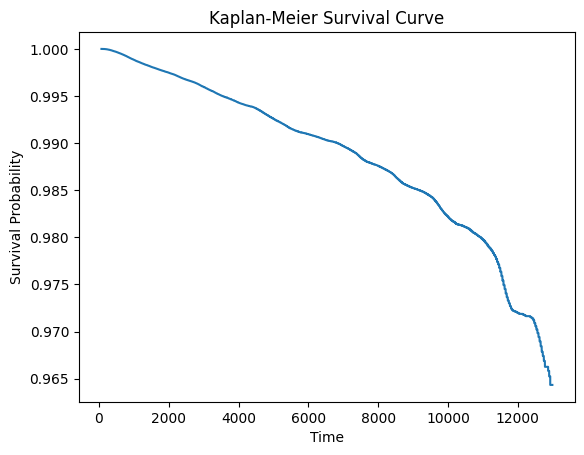

In [168]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

# Extract the time and status (event) data
time, status = np.array(df['Duration'], dtype=float), np.array(df['Default'], dtype=bool)

# Estimate the Kaplan-Meier survival curve
time, survival_prob = kaplan_meier_estimator(status, time)

# Plot the Kaplan-Meier survival curve
plt.step(time, survival_prob, where="post")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Kaplan-Meier Survival Curve")
plt.show()

In [169]:
from datetime import datetime

date2022 = datetime(2022, 1, 1)
train_df = df[df["date"] < date2022]
test_df = df[df["date"] >= date2022]
print("train_df shape:", train_df.shape)
print("test_df shape:", test_df.shape)

train_df shape: (1142877, 52)
test_df shape: (36537, 52)


In [170]:
selected_features = ['StkIndx', 'STInt', 'dtdlevel', 'dtdtrend',
        'liqnonfinlevel', 'liqnonfintrend', 'ni2talevel', 'ni2tatrend',
        'sizelevel', 'sizetrend', 'm2b', 'sigma', 'liqfinlevel', 'lqfintrend',
        'DTDmedianFin', 'DTDmedianNonFin', 'dummy297fin', 
        'current_ratio', 'quick_ratio', 'cash_ratio', 'net_working_capital',
        'debt_ratio', 'debt_to_equity_ratio', 'equity_ratio',
        'cashflow_to_debt_ratio', 'net_profit_margin', 'return_on_assets',
        'asset_turnover', 'inventory_turnover', 'days_in_inventory',
        'receivables_turnover', 'day_sales_outstanding',
        'working_capital_turnover', 'price_to_earnings',
        'dividend_payout_ratio', 'retention_ratio', 'gross_margin_ratio',
        'operating_profit_margin', 'ebitda_margin',
        'debt_service_coverage_ratio', 'interest_coverage_ratio']

In [171]:
X_train = train_df[selected_features]
y_train_df = train_df[['Default', 'Duration']]

In [172]:
print(y_train_df.head())

   Default  Duration
0    False     914.0
1    False    1848.0
2    False    3785.0
3    False    2786.0
4    False     472.0


In [173]:
y_train = np.array(y_train_df.to_records(index=False))
print(y_train)

[(False,   914.) (False,  1848.) (False,  3785.) ... (False, 12415.)
 (False,  9753.) (False,  3844.)]


In [177]:
model = CoxPHSurvivalAnalysis()
model.fit(X_train, y_train)

c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\linear_model\coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=3.02805e-19): result may not be accurate.
  delta = solve(
c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\linear_model\coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=6.76826e-22): result may not be accurate.
  delta = solve(
c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\linear_model\coxph.py:173: RuntimeWarning: overflow encountered in exp
  risk_set += np.exp(xw[k])
c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\linear_model\coxph.py:170: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])
c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\linear_model\coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=2.25084e-20): result may not be accurate.
  delta = solve

CoxPHSurvivalAnalysis()

In [190]:
X_test = test_df[selected_features]
y_test_df = test_df[['Default', 'Duration']]
y_test = np.array(y_test_df.to_records(index=False))

In [196]:
# Predict survival functions for each row in X_test
survival_functions = model.predict(X_test)

# Define the specific time point (in days) for which you want to obtain survival probabilities
specific_time_point = 365  # Adjust this as needed

# Initialize a list to store the survival probabilities at the specific time point
survival_probabilities = []

# Iterate through the survival functions and extract the survival probability at the specific time point
for i, survival_function in enumerate(survival_functions):
    survival_probability = survival_function[i]  # Use [i] to access the i-th prediction
    survival_probabilities.append(survival_probability)

# 'survival_probabilities' now contains the survival probabilities for each data point at the specific time point
print(survival_probabilities)


IndexError: invalid index to scalar variable.

In [ ]:
result = concordance_index_censored(y_test['Default'], -model.predict(X_test), y_test['Duration'])

print("C-Index:", result[0])

C-Index: 0.41081749404424717


In [197]:
prediction = model.predict(X_test)

c_index = model.score(X_test, y_test)
print(f"Concordance Index (C-index): {c_index:.4f}")

Concordance Index (C-index): 0.5000


In [ ]:
# Calculate predicted survival probabilities for the test data
survival_probs = model.predict_survival_function(X_test)

y_prob_array = []

time_points = [12 * 30]  # Specify the time point (12 months)

# Extract the probability at each time point
for t in time_points:
    # Use indexing to get the survival probability at the specified time point
    y_prob = [1.0 - survival_probs[0](t) for _ in range(len(X_test))]

    y_prob_array.append(y_prob)

# y_prob_array now contains an array of predicted probabilities for the specified time point (12 months)
 
print(survival_prob)

[1.         1.         1.         ... 0.96434071 0.96434071 0.96434071]


In [ ]:
y_prob_array = np.array(y_prob_array)  # Convert to a NumPy array
shape = y_prob_array.shape

print("Shape of y_prob_array:", shape)

Shape of y_prob_array: (1, 36537)
[[0.00016423 0.00016423 0.00016423 ... 0.00016423 0.00016423 0.00016423]]


In [ ]:
y_test_df['Binary_Default'] = y_test_df['Default'].map(lambda x : 0.0 if x == False else 1.0)
array_y = np.array(y_test_df['Binary_Default'])  # Convert to a NumPy array
shape = array_y.shape

print("Shape of array_y:", shape)

Shape of array_y: (36537,)


C:\Users\Melissa\AppData\Local\Temp\ipykernel_21624\67081832.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_df['Binary_Default'] = y_test_df['Default'].map(lambda x : 0.0 if x == False else 1.0)


In [ ]:
# Assuming you have your y_prob_array
unique_values = np.unique(y_prob_array)

print("Unique values in y_prob_array:", unique_values)

Unique values in y_prob_array: [0.00016423]


In [ ]:
print(y_prob_array, array_y)

[[0.00016423 0.00016423 0.00016423 ... 0.00016423 0.00016423 0.00016423]] [0. 0. 0. ... 0. 0. 0.]


In [ ]:
from sklearn.metrics import roc_auc_score

# Assuming you have the true labels (y_true) and predicted probabilities (y_prob) for a binary classification task
# y_true should contain binary labels (0 or 1), and y_prob should contain predicted probabilities for class 1

# Calculate the AUC
auc = roc_auc_score(array_y, survival_prob)

# Print the AUC score
print(f"AUC: {auc:.4f}")


ValueError: Found input variables with inconsistent numbers of samples: [36537, 12505]

In [ ]:
y_train_binary = np.array([(int(value), duration) for value, duration in y_train],
                        dtype=[('Default', 'i1'), ('Duration', '<f8')])

print(y_train_binary)

[(0,   914.) (0,  1848.) (0,  3785.) ... (0, 12415.) (0,  9753.)
 (0,  3844.)]


In [ ]:
false_count = (y_train_df['Default'] == False).sum()
print("Number of False under 'Default' column:", false_count)

true_count = (y_train_df['Default'] == True).sum()
print("Number of True under 'Default' column:", true_count)

Number of False under 'Default' column: 1133711
Number of True under 'Default' column: 9166


In [ ]:
false_count = (y_test_df['Default'] == False).sum()
print("Number of False under 'Default' column:", false_count)

true_count = (y_test_df['Default'] == True).sum()
print("Number of True under 'Default' column:", true_count)

Number of False under 'Default' column: 36381
Number of True under 'Default' column: 156
